In [18]:
import torch
import pandas as pd
import json
import transformer_ee.dataloader.string_conv as string_conv
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset


In [19]:
mps_device = torch.device("mps")

In [20]:
df = pd.read_csv(
    "transformer_ee/data/2022-08-21_rnne_NC_250_fGScatter_20MeV_KE_01e8_max_trackE_cut.csv.xz"
)

with open("transformer_ee/config/input.json", "r") as f:
    input_d = json.load(f)


In [21]:
for particle_feature in input_d["vector"]:
    df[particle_feature] = df[particle_feature].apply(string_conv.string_to_float_list)


In [22]:
class Pandas_NC_Dataset(Dataset):
    def __init__(self, dataframe, config: dict):
        self.df = dataframe
        self.len = len(dataframe)
        self.maxpronglen = config["max_num_prongs"]
        self.vectornames = config["vector"]
        self.scalarnames = config["scalar"]
        self.targetname = config["target"]

        # calculate mean and std for normalization
        self.stat_scalar = []
        for x in self.scalarnames:
            self.stat_scalar.append([df[x].mean(), df[x].std()])
        self.stat_scalar = torch.Tensor(self.stat_scalar).T
        self.stat_scalar = self.stat_scalar[:, None, :]

        self.stat_vector = []
        for x in self.vectornames:
            _tmp = []
            for y in df[x]:
                _tmp.extend(y)
            self.stat_vector.append([np.mean(_tmp), np.std(_tmp)+1E9])
        self.stat_vector = torch.Tensor(self.stat_vector).T
        self.stat_vector = self.stat_vector[:, None, :]
        self.d = {}

    def __getitem__(self, index):
        if index in self.d:
            return self.d[index]

        row = self.df.iloc[index]
        _vectorsize = len(row[self.vectornames[0]])
        _vector = torch.Tensor(row[self.vectornames]).T
        _scalar = torch.Tensor(row[self.scalarnames]).T
        _vector = _vector / self.stat_vector[1]
        _scalar = _scalar / self.stat_scalar[1]

        return_tuple = (
            # pad the vector to maxpronglen with zeros
            F.pad(_vector, (0, 0, 0, self.maxpronglen - _vectorsize), "constant", 0),
            # return the scalar
            _scalar,
            # return src_key_padding_mask
            F.pad(
                torch.zeros(_vectorsize, dtype=torch.bool),
                (0, self.maxpronglen - _vectorsize),
                "constant",
                1,  # pad with True
            ),
            torch.Tensor(row[self.targetname]),
        )
        self.d[index] = return_tuple
        return return_tuple

    def __len__(self):
        return self.len


In [23]:
dataset = Pandas_NC_Dataset(df, input_d)

batch_size_train = 256
batch_size_test = 10000


In [24]:
seed = 0
_indices = np.arange(len(df))
np.random.seed(seed)
np.random.shuffle(_indices)
test_size = 0.2
train_indicies = _indices[: int(len(_indices) * (1 - test_size))]
test_indicies = _indices[int(len(_indices) * (1 - test_size)) :]

In [25]:
from torch.utils.data import Subset

train_dataset = Subset(dataset, train_indicies)
test_dataset = Subset(dataset, test_indicies)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train,
                                            shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test,
                                            shuffle=False)

In [26]:
from transformer_ee.model.transformerEncoder import Transformer_EE_v1
net=Transformer_EE_v1().to(mps_device)

In [27]:
import torch.optim as optim
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [15]:
loss_list = []
epochs = 100
error_list = []
lossfunc = nn.MSELoss()

for i in range(epochs):

    net.train()  # begin training

    for (batch_idx, batch) in enumerate(trainloader):
        vector_train_batch = batch[0].to(mps_device)
        scalar_train_batch = batch[1].to(mps_device)
        mask_train_batch = batch[2].to(mps_device)
        target_train_batch = batch[3].to(mps_device)

        Netout = net.forward(vector_train_batch, mask_train_batch)
        # This will call the forward function, usually it returns tensors.

        loss = 100 * torch.mean(
            torch.abs((Netout - target_train_batch) / target_train_batch)
        )  # regression loss

        # Zero the gradients before running the backward pass.
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to all the learnable
        # parameters of the model. Internally, the parameters of each Module are stored
        # in Tensors with requires_grad=True, so this call will compute gradients for
        # all learnable parameters in the model.
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()

        loss_list.append(loss)
        if batch_idx % 1 == 0:
            # print("Epoch: {}, batch: {} Loss: {} label_loss:{}".format(i, batch_idx, loss, label_loss_))
            print("Epoch: {}, batch: {} Loss: {:0.4f}".format(i, batch_idx, loss))


Epoch: 0, batch: 0 Loss: 53.3995
Epoch: 0, batch: 1 Loss: 46.7878
Epoch: 0, batch: 2 Loss: 52.6341
Epoch: 0, batch: 3 Loss: 43.4750
Epoch: 0, batch: 4 Loss: 42.5742
Epoch: 0, batch: 5 Loss: 50.4289
Epoch: 0, batch: 6 Loss: 46.7080
Epoch: 0, batch: 7 Loss: 46.6980
Epoch: 0, batch: 8 Loss: 45.4777
Epoch: 0, batch: 9 Loss: 46.3776
Epoch: 0, batch: 10 Loss: 45.4019
Epoch: 0, batch: 11 Loss: 44.6175
Epoch: 0, batch: 12 Loss: 45.7471
Epoch: 0, batch: 13 Loss: 46.6543
Epoch: 0, batch: 14 Loss: 51.5191
Epoch: 0, batch: 15 Loss: 51.6155
Epoch: 0, batch: 16 Loss: 46.5435
Epoch: 0, batch: 17 Loss: 45.4299
Epoch: 0, batch: 18 Loss: 45.1085
Epoch: 0, batch: 19 Loss: 46.1798
Epoch: 0, batch: 20 Loss: 47.8804
Epoch: 0, batch: 21 Loss: 46.1010
Epoch: 0, batch: 22 Loss: 49.0950
Epoch: 0, batch: 23 Loss: 50.1267
Epoch: 0, batch: 24 Loss: 44.4770
Epoch: 0, batch: 25 Loss: 46.7629
Epoch: 0, batch: 26 Loss: 48.8735
Epoch: 0, batch: 27 Loss: 47.5277
Epoch: 0, batch: 28 Loss: 46.8736
Epoch: 0, batch: 29 Loss

KeyboardInterrupt: 

In [17]:
torch.save(net.state_dict(), "transformer_ee/model/transformer_ee_v1.pt")


In [28]:
from transformer_ee.model.transformerEncoder import Transformer_EE_v1

net=Transformer_EE_v1()
net.load_state_dict(torch.load("transformer_ee/model/transformer_ee_v1.pt"))
net.eval()

Transformer_EE_v1(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=12, out_features=12, bias=True)
        )
        (linear1): Linear(in_features=12, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=12, bias=True)
        (norm1): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=12, out_features=12, bias=True)
        )
        (linear1): Linear(in_features=12, out_features=2048, bias=True)
        (dropout): Dropout(

mean resolution:  -0.06467003
std resolution:  0.35195076
rms resolution:  0.35784292


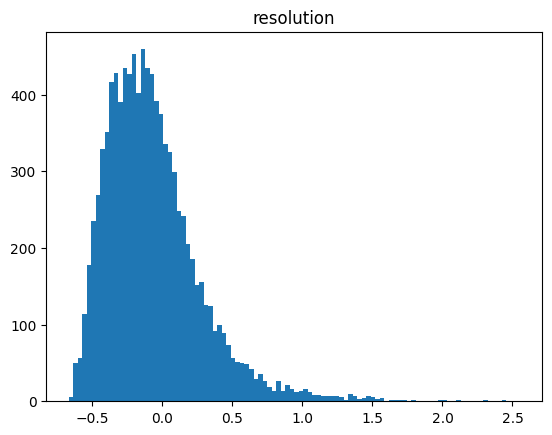

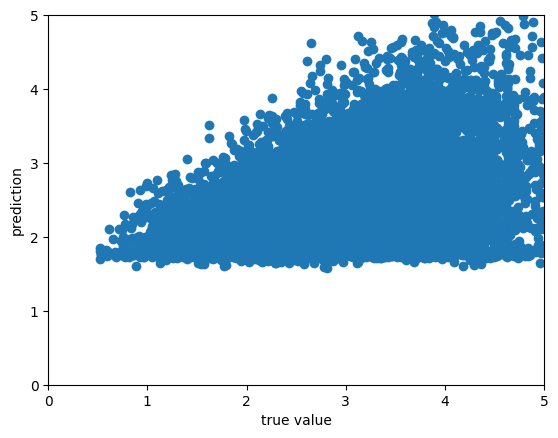

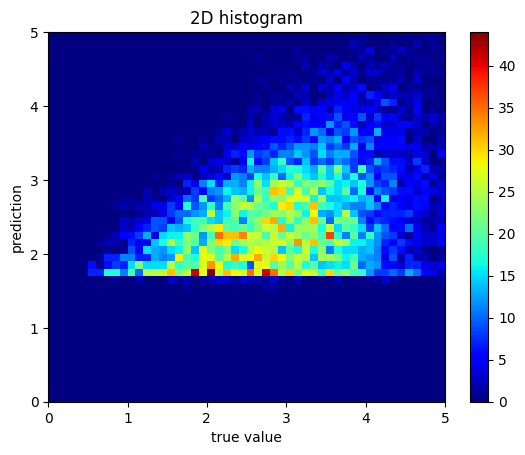

In [31]:
net.eval()
net.to(mps_device)
a, b, c, d=next(iter(testloader))
net.cpu()
e=net.forward(a, c)

from matplotlib import pyplot as plt
trueval=d[:, 0].cpu().detach().numpy()
prediction=e[:, 0].cpu().detach().numpy()
resolution=(prediction-trueval)/trueval
print("mean resolution: ", np.mean(resolution))
print("std resolution: ", np.std(resolution))
print('rms resolution: ', np.sqrt(np.mean(resolution**2)))
plt.title("resolution")
plt.hist(resolution, bins=100)
plt.show()

plt.scatter(trueval, prediction)
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.xlabel("true value")
plt.ylabel("prediction")
plt.show()

net.to(mps_device)
plt.hist2d(trueval, prediction, bins=(50, 50), cmap=plt.cm.jet, range=[[0, 5], [0, 5]])
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.xlabel("true value")
plt.ylabel("prediction")
plt.title("2D histogram")
plt.colorbar()
plt.show()

In [27]:
np.sum(np.array(a[:, :, 0], dtype=bool), axis=1)

array([ 3,  3, 12, ...,  3, 11,  4])